In [1]:
import glob
import zipfile
import numpy as np
import pandas as pd
import os
import IPython

import numpy as np
import soundfile as sf
import torch
import yaml
import matplotlib.pyplot as plt

from tqdm import tqdm

from torchvision.io import read_video
import scipy.io
import skvideo.io
from dtw import *;
from skimage.draw import polygon
import shutil


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [9]:
# def load_segments(track_mat_path):
#     mat = scipy.io.loadmat(track_mat_path)
#     res = mat['trackdata']
#     t = 0
#     frame = res[0][t][0][0][0][0][0][0][0]
#     segment0 = frame[0][0][0]
#     segment0_i = segment0[1]
#     segment1 = frame[1][0][0]
#     segment1_i = segment1[1]
#     segment2 = frame[2][0][0]
#     segment2_i = segment2[1]
#     return segment0_i, segment1_i, segment2_i


# def mat2npy(track_mat_path):
#     mat = scipy.io.loadmat(track_mat_path)
#     res = mat['trackdata'][0]
#     num_frames = len(res)
#     track_array = []
#     for t in range(num_frames):
#         frame_array = []
#         frame = res[t][0][0][0][0][0][0][0]
#         segment0 = frame[0][0][0]
#         segment1 = frame[1][0][0]
#         segment2 = frame[2][0][0]
#         segment0_v = segment0[0]
#         segment1_v = segment1[0]
#         segment2_v = segment2[0]
#         frame_array.append(segment0_v)
#         frame_array.append(segment1_v)
#         frame_array.append(segment2_v)
#         frame_array = np.concatenate(frame_array, axis=0)  # (170, 2)
#         frame_array = np.expand_dims(frame_array, axis=0)  # (1, 170, 2)
#         track_array.append(frame_array)
#     track_array = np.concatenate(track_array, axis=0)  # (Y, 170, 2)
#     track_array = track_array.reshape(track_array.shape[0], -1)  # (T, 340)
#     return track_array


# def convert2pltorder340(arr):
#     """
#     Args
#         arr: shape (seq_len, 340)
#             feat_list = [feat0[:, 0], feat0[:, 1], 
#                          feat1[:, 0], feat1[:, 1],
#                          feat2[:, 0], feat2[:, 1]]

#     Return:
#         track_array: shape (seq_len, 340)
#             feat0 (70), feat1 (40), feat2 (60)
#         track_array_xy: shape (seq_len, 170, 2)
#     """
#     track_array = []
#     for carr in arr:
#         feat0_x = carr[:70]
#         feat0_y = carr[70:140]
#         feat1_x = carr[140:180]
#         feat1_y = carr[180:220]
#         feat2_x = carr[220:280]
#         feat2_y = carr[280:]
#         frame_array = np.stack([np.concatenate([feat0_x, feat1_x, feat2_x]), np.concatenate([feat0_y, feat1_y, feat2_y])], axis=0).transpose(1, 0)  # (170, 2)
#         track_array.append(frame_array)
#     track_array_xy = np.stack(track_array, axis=0)  # (Y, 170, 2)
#     track_array = track_array_xy.reshape(track_array_xy.shape[0], -1)
#     return track_array, track_array_xy


# def draw_new_rtMRI(mri_data, segment_0, segment_1, segment_2, title, plot_oup):
#     """
#     Args:
#         mri_data: shape (seq_len, 340)
#         segment_0: shape (70, 1)
#     """
#     print('mri_data', mri_data.shape)
#     feat_dim = mri_data.shape[1]

#     segment_0 = list(segment_0.reshape(-1))
#     segment_1 = list(segment_1.reshape(-1))
#     segment_2 = list(segment_2.reshape(-1))

#     segment_1 = list(len(set(segment_0)) + np.array(segment_1))
#     segment_2 = list(len(set(segment_0+segment_1)) + np.array(segment_2))
    
#     segment_labs = segment_0 + segment_1 + segment_2
#     art_labs = []
#     art_labs_unique = []
#     for i in range(10):
#         art_labs.append("epiglottis")
#     art_labs_unique.append("epiglottis")
#     for i in range(10, 30):
#         art_labs.append("tongue")
#     art_labs_unique.append("tongue")
#     for i in range(30,35):
#         art_labs.append("lower teeth")
#     art_labs_unique.append("lower teeth")
#     for i in range(35,45):
#         art_labs.append("lower lip")
#     art_labs_unique.append("lower lip")
#     for i in range(45,60):
#         art_labs.append("chin")
#     art_labs_unique.append("chin")
#     for i in range(60,70):
#         art_labs.append("neck")
#     art_labs_unique.append("neck")
#     for i in range(70,80):
#         art_labs.append("arytenoid")
#     art_labs_unique.append("arytenoid")
#     for i in range(80,90):
#         art_labs.append("pharynx")
#     art_labs_unique.append("pharynx")
#     for i in range(90,105):
#         art_labs.append("back")
#     art_labs_unique.append("back")
#     for i in range(105, 110):
#         art_labs.append("trachea")
#     art_labs_unique.append("trachea")
#     for i in range(110, 120):
#         art_labs.append("hard palate")
#     art_labs_unique.append("hard palate")
#     for i in range(120, 135):
#         art_labs.append("velum")
#     art_labs_unique.append("velum")
#     for i in range(135,150):
#         art_labs.append("nasal cavity")
#     art_labs_unique.append("nasal cavity")
#     for i in range(150, 160):
#         art_labs.append("nose")
#     art_labs_unique.append("nose")
#     for i in range(160, 170):
#         art_labs.append("upper lip")
#     art_labs_unique.append("upper lip")
    
#     data_x = []
#     data_y = []
#     for i in range(feat_dim//2):
#         data_x.append(mri_data[:,i*2])
#         data_y.append(mri_data[:,i*2+1])
#     data_x = np.array(data_x)  # (170, 61)

#     fig = plt.figure(figsize=(10, 10))

#     len_data = len(data_x[0])

#     colors = ['red', 'orange', 'lawngreen', 'lightgreen', 'aqua', 'deepskyblue', 'royalblue', 'blueviolet',\
#           'fuchsia', 'yellow', 'crimson', 'thistle', 'cadetblue', 'lightgrey', 'lawngreen', 'slategray', 'peachpuff',\
#          'maroon', 'ivory', 'black', 'darkgrey', 'dimgrey']
    
#     num_parts = np.max(segment_labs)
#     seg_indices = [[] for _ in range(num_parts)]    
#     for i in range(len(segment_labs)):
#         seg_indices[segment_labs[i]-1].append(i)

#     data_x = np.array(data_x)  # (170, 61)
#     data_y = np.array(data_y)  # (170, 61)

#     num_plots = 8 # 9
#     clen = data_x.shape[1]
#     delta = clen // (num_plots-1)
#     alphas = np.arange(num_plots)/num_plots

#     part_idxs = [i for i in range(num_parts)]
#     # part_idxs.remove(8)
#     for i in part_idxs:
#         seg_ind = np.array(seg_indices[i])
#         cdata_x = data_x[seg_ind]  #  eg (10, 61)
#         cdata_y = data_y[seg_ind]  #  eg (10, 61)

#         plt.plot(cdata_x[:,0], cdata_y[:,0], color=colors[i], alpha=alphas[0], linewidth=1)
#         for plot_idx in range(1, num_plots-1):
#             plt.plot(cdata_x[:,delta*plot_idx], cdata_y[:,delta*plot_idx], color=colors[i], alpha=alphas[plot_idx], linewidth=1)
#         plt.plot(cdata_x[:,delta*(num_plots-1)], cdata_y[:,delta*(num_plots-1)], color=colors[i], alpha=alphas[-1], linewidth=1, label=art_labs_unique[i])

#     ema_labels = ['upper lip', 'lower lip', 'lower incisor', 'tongue tip', 'tongue blade', 'tongue dorsum']
#     ema_feat_idxs = [163, 40, 34, 28, 23, 18]
#     ema_markers = ['s', 'o', 'v', 'v', 'o', 's']
#     ema_colors = ['lawngreen', 'lightgreen', 'lawngreen', 'orange', 'orange', 'orange']
#     pointsize = 128
#     for ema_i in range(len(ema_labels)):
#         plt.scatter(data_x[ema_feat_idxs[ema_i],0], data_y[ema_feat_idxs[ema_i],0], color=ema_colors[ema_i], alpha=alphas[0], marker=ema_markers[ema_i], edgecolor='black', linewidth=1, s=pointsize)
#         for plot_idx in range(1, num_plots-1):
#             plt.scatter(data_x[ema_feat_idxs[ema_i],delta*plot_idx], data_y[ema_feat_idxs[ema_i],delta*plot_idx], color=ema_colors[ema_i], alpha=alphas[plot_idx], marker=ema_markers[ema_i], edgecolor='black', linewidth=1, s=pointsize)
#         plt.scatter(data_x[ema_feat_idxs[ema_i],delta*(num_plots-1)], data_y[ema_feat_idxs[ema_i],delta*(num_plots-1)], color=ema_colors[ema_i], alpha=alphas[-1], marker=ema_markers[ema_i], edgecolor='black', linewidth=1, s=pointsize, label=ema_labels[ema_i])

#     plt.xticks([])
#     plt.yticks([])
#     plt.legend(loc='lower left')
#     # plt.title(title, fontdict={'fontsize' : 50})
#     plt.savefig(plot_oup, dpi=300)
#     plt.clf()

In [10]:
# ri_data_d = '/home/all_data/mri'
# spkr = 'F_25_Napa_sub071'
# tracks_d = os.path.join(mri_data_d, spkr, 'tracks')
# mat_p = os.path.join(tracks_d, 'usc_vtsf_F_25_Napa_rt_vcv_r1s1_track.mat')# 'usc_vtsf_F_25_Napa_rt_bVt_r1_track.mat')
# fid = 'F_25_Napa_vcv_r1s1_0' # 'F_25_Napa_bVt_r1_14'
# feat_p = os.path.join(mri_data_d, spkr, 'tracks_npy_340_punc', '%s.npy' % fid)
# text_p = os.path.join(mri_data_d, spkr, 'text_punc', '%s.txt' % fid)
# with open(text_p, 'r') as inf:
#     lines = inf.readlines()
# line = lines[0].strip()
# title = '_'.join(line.split())
# print(title)
# oud = 'outputs/outputs_plots'
# if not os.path.exists(oud):
#     os.makedirs(oud)
# plot_oup = oud+'/'+title+"_340_2d"+".jpg"

# segment0, segment1, segment2 = load_segments(mat_p)
# arr0 = np.load(feat_p)
# track_npy, _ = convert2pltorder340(arr0)
# # draw_new_rtMRI(track_npy, segment0, segment1, segment2, title, plot_oup)

apa


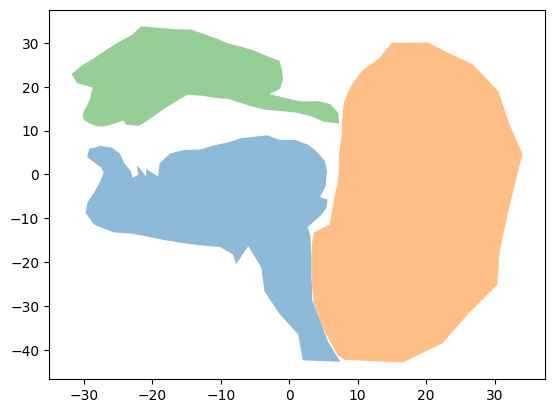

In [12]:
i = 45

plt.fill(*track_npy_2d[i, :70].T, alpha = 0.5)
plt.fill(*track_npy_2d[i, 70:110].T, alpha = 0.5)
plt.fill(*track_npy_2d[i, 110:].T, alpha = 0.5)

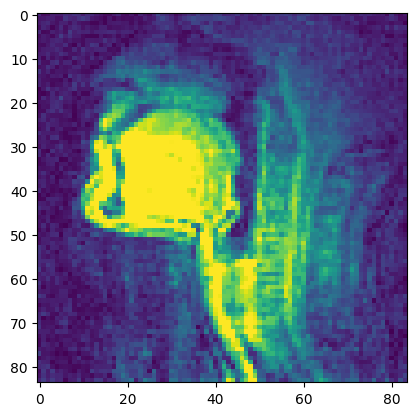

In [106]:
plt.imshow(a.mean(axis = 3)[0])

In [2]:
np.version.version

'1.23.5'

In [3]:
speakers = [ 'sacramento', 'napa', 'houston', 'brawley', 'missionviejo', 'pasadena', 'dallas', 'medina' ]
mri_directory = glob.glob('home/all_data/mri/*')
all_images = []
all_segmentations = []
for speaker in speakers:
    frames = []
    segmentations = []
    tracks_files = glob.glob([sp_dir for sp_dir in mri_directory if speaker.casefold() in sp_dir.casefold()][0] + '/tracks/*')
    video_zip = [f for f in glob.glob(f'home/all_data/mri_videos/{speaker}/*') if 'withaudio' not in f][0]
    with zipfile.ZipFile(video_zip, 'r') as zip_ref:
        zip_ref.extractall('./mri_vids/')
    video_files = glob.glob('./mri_vids/avi/*')
    for video in video_files:
        name = video[video.find('_rt_') + 4:-4]
        track = [t for t in tracks_files if name in t]
        if len(track) == 0:
            continue
        track = scipy.io.loadmat(track[0])['trackdata']
        seg_loader = lambda frame,seg: (track[0][frame][0,0][0][0,0][0][0,seg][0,0][0]) + 42
        vid = skvideo.io.vread(video).mean(axis = 3)/255
        if track[0].shape[0] != vid.shape[0]:
            continue
        segment = []
        for i in range(0, vid.shape[0], 10):
            seg0 = seg_loader(i,0)
            seg1 = seg_loader(i,1)
            seg2 = seg_loader(i,2)
            image = np.zeros((3,84,84))
            rr0,cc0 = polygon(seg0[:,0], seg0[:,1], image[0].shape)
            image[0,rr0,cc0] = 1
            image[0] = np.rot90(image[0])
            rr1,cc1 = polygon(seg1[:,0], seg1[:,1], image[1].shape)
            image[1,rr1,cc1] = 1
            image[1] = np.rot90(image[1])
            rr2,cc2 = polygon(seg2[:,0], seg2[:,1], image[2].shape)
            image[2,rr2,cc2] = 1
            image[2] = np.rot90(image[2])  
            segment.append(image)
        segmentations.append(np.array(segment))      
        frames.append(vid[::10])
    shutil.rmtree('./mri_vids/avi/', ignore_errors=True)
    if len(frames) != 0:
        all_images.append(np.concatenate(frames))
        all_segmentations.append(np.concatenate(segmentations))
    else: 
        print(speaker)

In [3]:
train_images = np.concatenate(all_images[:6])
train_segmentations = np.concatenate(all_segmentations[:6])
np.save('./MRI_Segmentation/train_images.npy', train_images)
np.save('./MRI_Segmentation/train_segmentations.npy', train_segmentations)
test_images = all_images[6]
test_segmentations = all_segmentations[6]
np.save('./MRI_Segmentation/test_images.npy', test_images)
np.save('./MRI_Segmentation/test_segmentations.npy', test_segmentations)

In [ ]:
all_images = np.concatenate(all_images)
all_segmentations = np.concatenate(all_segmentations)
shuffle_order = np.arange(all_images.shape[0])
np.random.shuffle(shuffle_order)
all_images = all_images[shuffle_order]
all_segmentations = all_segmentations[shuffle_order]
np.save('./MRI_Segmentation/images.npy', all_images)
np.save('./MRI_Segmentation/segmentations.npy', all_segmentations)

In [192]:
all_images[:,np.newaxis,:,:].shape

(32198, 1, 84, 84)

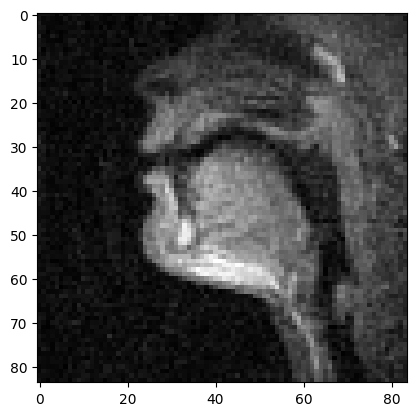

In [201]:
point = 23456
im = all_images[point]
seg = all_segmentations[point]
plt.imshow(im, cmap='gray')
plt.imshow(seg.mean(axis = 0), cmap='gray', alpha = 0.0)

In [181]:
t_im = all_images[1500]
t_seg = all_segmentations[0][1500]
plt.imshow(t_im, cmap='gray')
plt.imshow(t_seg.mean(axis = 0), cmap='gray', alpha = 0.3)

IndexError: index 1500 is out of bounds for axis 0 with size 84

In [100]:
'./mri_vids/avi/usc_vtsf_F_18_Sacramento_rt_northwind_r2s2.avi'[39 + 4:-4]

'northwind_r2s2'

In [2]:
napa_vids = glob.glob('home/all_data/mri_videos/napa/avi-20230404T164114Z-001.zip')
napa_vids

['home/all_data/mri_videos/napa/avi-20230404T164114Z-001.zip']

In [3]:
l = None
with zipfile.ZipFile(napa_vids[0], 'r') as zip_ref:
    l = zip_ref.filelist
    zip_ref.extract('avi/usc_vtsf_F_25_Napa_rt_vcv_r1s1.avi', './test_seg/')
    

In [17]:
len(l), l

(28,
 [<ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_picture1.avi' compress_type=deflate file_size=19309784 compress_size=19312734>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_rainbow_r2.avi' compress_type=deflate file_size=24094184 compress_size=24097864>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_bVt_r1.avi' compress_type=deflate file_size=17445640 compress_size=17448305>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_shibboleth_r2.avi' compress_type=deflate file_size=14865608 compress_size=14867878>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_shibboleth_r1.avi' compress_type=deflate file_size=14893960 compress_size=14896235>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_vcv_r2s1.avi' compress_type=deflate file_size=16751016 compress_size=16753576>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_picture2.avi' compress_type=deflate file_size=19444456 compress_size=19447426>,
  <ZipInfo filename='avi/usc_vtsf_F_25_Napa_rt_picture4.avi' compress_type=deflate file_size=192

In [11]:
temp_images = np.load('./temp_seg/images.npy', allow_pickle=True)

In [20]:
([i.shape[0] for i in temp_images])

[6571, 1522, 7163, 7225, 6891, 2100, 726]

In [ ]:
np.save("./test_out.npy", np.array([]))

In [71]:
a = skvideo.io.vread("test_seg/avi/usc_vtsf_F_25_Napa_rt_vcv_r1s1.avi")

In [14]:
a.shape

(3137, 84, 84, 3)

In [107]:
a[0].shape

(84, 84, 3)

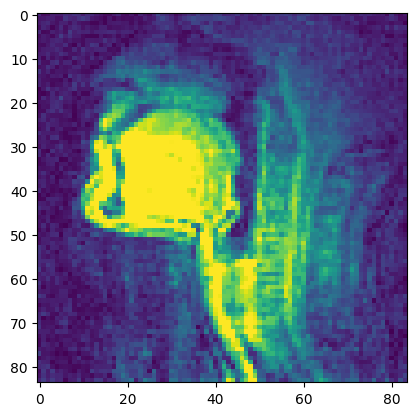

In [15]:
plt.imshow(a[0].mean(axis=2))

In [36]:
tem = np.load('home/all_data/mri/F_25_Napa_sub071/tracks_npy_340/F_25_Napa_vcv_r1s1.npy')

In [65]:
((t[0][1500][0,0][0][0,0][0][0,1][0,0][0] * np.array([1,-1])) + 42).shape

(40, 2)

In [36]:
e,g = np.load('home/all_data/mri/F_18_Sacramento_sub047/tracks_npy_scaled/F_18_Sacramento_bVt_r1.npy'), np.load('home/all_data/mri/F_18_Sacramento_sub047/tracks_npy_full/F_18_Sacramento_bVt_r1.npy')

In [40]:
g/e

array([[156.78940321, 200.99388749,  53.76334166, ...,  -7.27416973,
        -15.83635557, -27.40259761],
       [117.26828718, 122.05016418,  49.92942436, ...,  -5.02743837,
        -11.91724787, -19.98436654],
       [114.36461845, 119.1340511 ,  47.76217517, ...,  -2.23064186,
        -12.0693982 , -17.10164246],
       ...,
       [171.5278573 , 189.14294062,  75.13317144, ...,  -8.77914245,
        -18.82289571, -38.71580649],
       [140.74788277, 140.12701371,  69.35843889, ..., -11.13054288,
        -13.17744303, -14.33421048],
       [163.83196348, 142.57135619,  62.51244235, ..., -12.11335641,
        -19.10752568, -64.22427713]])

In [21]:
w(0,0).shape

(70, 2)

In [19]:
t = scipy.io.loadmat('home/all_data/mri/F_25_Napa_sub071/tracks/usc_vtsf_F_25_Napa_rt_vcv_r1s1_track.mat')['trackdata']

In [41]:
w = lambda a,b: (t[0][a][0,0][0][0,0][0][0,b][0,0][0] * np.array([1,-1])) + 42

In [61]:
w2 = lambda a,b: (t[0][a][0,0][0][0,0][0][0,b][0,0][0]) + 42

In [64]:
temp0 = w2(1500,0)
temp1 = w2(1500,1)
temp2 = w2(1500,2)

In [81]:
a[1500].mean(axis=2)/255

array([[0.05490196, 0.02745098, 0.05882353, ..., 0.01960784, 0.03137255,
        0.        ],
       [0.03529412, 0.05882353, 0.01568627, ..., 0.04313725, 0.02352941,
        0.03529412],
       [0.01960784, 0.0745098 , 0.03137255, ..., 0.05098039, 0.05490196,
        0.03137255],
       ...,
       [0.01960784, 0.01960784, 0.01960784, ..., 0.04705882, 0.00784314,
        0.05098039],
       [0.03529412, 0.06666667, 0.09019608, ..., 0.14509804, 0.03137255,
        0.01176471],
       [0.03921569, 0.01568627, 0.03529412, ..., 0.09019608, 0.03921569,
        0.03921569]])

In [80]:
np.min(a[1500].mean(axis=2)), np.max(a[1500].mean(axis=2))

(0.0, 240.0)

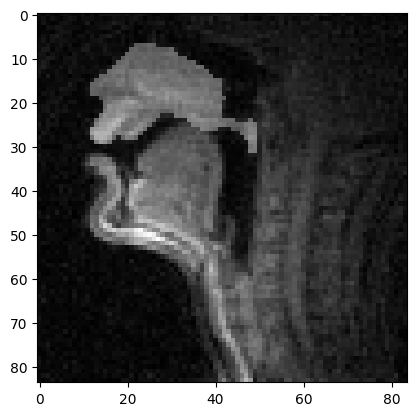

In [89]:
plt.imshow(a[1500].mean(axis=2) + 70*np.rot90(image), cmap='gray')

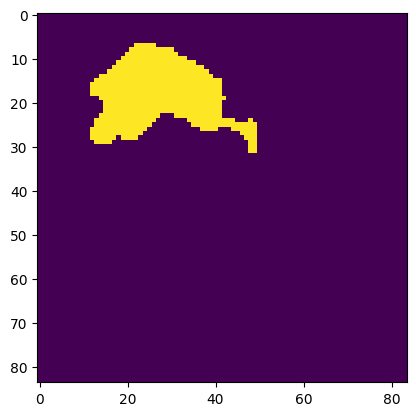

In [83]:
image = np.zeros((84,84))
rr,cc = polygon(temp2[:,0], temp2[:,1], image.shape)
image[rr,cc] = 1
plt.imshow(np.rot90(image))

In [84]:
# a = 0 # frame number
# b = 0 # segment [0,1,2]
# z = t[0][a][0,0][0][0,0][0][0,b][0,0][0]
# z.shape

In [2]:
test_images = np.load('./MRI_Segmentation/test_images.npy', allow_pickle=True)
test_segmentations = np.load('./MRI_Segmentation/test_segmentations.npy', allow_pickle=True)
test_images.shape, test_segmentations.shape

((726, 84, 84), (726, 3, 84, 84))

In [3]:
train_images = np.load('./MRI_Segmentation/train_images.npy', allow_pickle=True)
train_segmentations = np.load('./MRI_Segmentation/train_segmentations.npy', allow_pickle=True)
train_images.shape, train_segmentations.shape

((31472, 84, 84), (31472, 3, 84, 84))

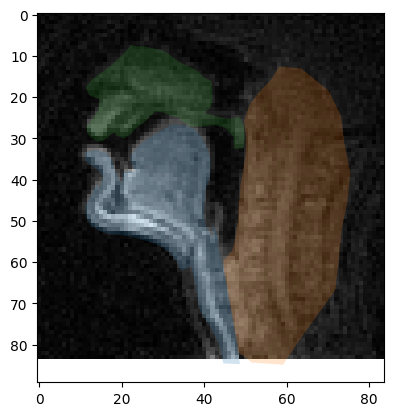

In [25]:
k = 1500
plt.imshow(a[k].mean(axis=2), cmap='gray')
plt.fill(*w(k,0).T, alpha = 0.2)
plt.fill(*w(k,1).T, alpha = 0.2)
plt.fill(*w(k,2).T, alpha = 0.2)

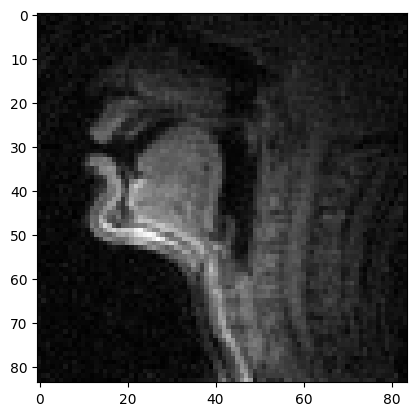

In [26]:
plt.imshow(a[k].mean(axis=2), cmap='gray')

In [13]:
test_segm.shape

(329, 310)

In [14]:
parse_mri_mat('home/all_data/mri/F_18_Sacramento_sub047/tracks/usc_vtsf_F_18_Sacramento_rt_bVt_r1_track.mat', test_out)

In [45]:
np.load('home/all_data/mri/F_25_Napa_sub071/hub_83/F_25_Napa_bVt_r1.npy').shape

(2452, 1024)

In [58]:
trackdata = scipy.io.loadmat(MRI_mats[0])['trackdata']

In [64]:
trackdata[0][0][0]

array([(array([[(array([[array([[(array([[ 11.80919807, -16.6057596 ],
                                      [ 11.69592431, -14.72764251],
                                      [ 12.29262986, -13.04237583],
                                      [ 12.51159505, -11.32234188],
                                      [ 12.95809546,  -9.65432952],
                                      [ 12.92398707,  -8.00966115],
                                      [ 12.00126548,  -6.58838975],
                                      [ 11.59787124,  -5.91603872],
                                      [ 11.52255134,  -7.09093353],
                                      [ 12.0258568 ,  -9.26834083],
                                      [ 12.37591735,  -9.50637066],
                                      [ 12.21612199,  -9.98476294],
                                      [ 11.64790955,  -9.66484882],
                                      [ 11.50277009,  -9.07783809],
                                      [ 10.57